## Full Portfolio Pipeline Report

In [1]:
# Stage 7.1 – Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")

PRICE_FILE = PROJECT_ROOT / "data" / "price_data.csv"
OPT_WEIGHTS = PROJECT_ROOT / "results" / "portfolios" / "optimized_weights.csv"

print(" Files loaded from:", PROJECT_ROOT)


 Files loaded from: D:\Portfolio Optimzation project


In [2]:
# Stage 7.2 – Load and prepare data
price_df = pd.read_csv(PRICE_FILE)
price_df["date"] = pd.to_datetime(price_df["date"], utc=True).dt.tz_localize(None)

weights_df = pd.read_csv(OPT_WEIGHTS)
weights_df["date"] = pd.to_datetime(weights_df["date"], utc=True).dt.tz_localize(None)

returns = price_df.pivot(index="date", columns="ticker", values="close_price").pct_change().dropna(how="all")

print(f"Price rows: {len(price_df):,}, Dates: {returns.index.min().date()} → {returns.index.max().date()}")
print(f"Unique rebalance dates: {weights_df['date'].nunique()}")


Price rows: 1,063,311, Dates: 2015-02-02 → 2025-08-25
Unique rebalance dates: 79


C:\Users\rajya\AppData\Local\Temp\ipykernel_26576\2112772012.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_df.pivot(index="date", columns="ticker", values="close_price").pct_change().dropna(how="all")


In [4]:
# Stage 7.3 – Backtest with turnover & transaction cost
TRANSACTION_COST = 0.001  # 0.1%
INITIAL_CAPITAL = 1_000_000

rebalance_dates = sorted(weights_df["date"].unique())
pf_daily = pd.Series(index=returns.index, dtype=float)
prev_w = pd.Series(0.0, index=returns.columns)
turnover_series = []

for i, d in enumerate(rebalance_dates):
    w = weights_df[weights_df["date"] == d].set_index("ticker")["w_mvo_best_sharpe"]
    mask = (returns.index >= d)
    if i + 1 < len(rebalance_dates):
        mask &= (returns.index < rebalance_dates[i + 1])
    
    # Compute daily returns and apply weights
    r = returns.loc[mask]
    port_ret = (r * w.reindex(r.columns).fillna(0)).sum(axis=1)
    
    # Transaction cost and turnover
    turnover = 0.5 * np.abs(w - prev_w).sum()
    tc_cost = turnover * TRANSACTION_COST
    port_ret -= tc_cost / len(r)  # spread cost across period
    
    pf_daily.loc[r.index] = port_ret.values
    turnover_series.append({"date": d, "turnover": turnover})
    prev_w = w.copy()

# Convert to cumulative values
pf_value = (1 + pf_daily.fillna(0)).cumprod() * INITIAL_CAPITAL
turnover_df = pd.DataFrame(turnover_series)
print(" Backtest completed.")


 Backtest completed.


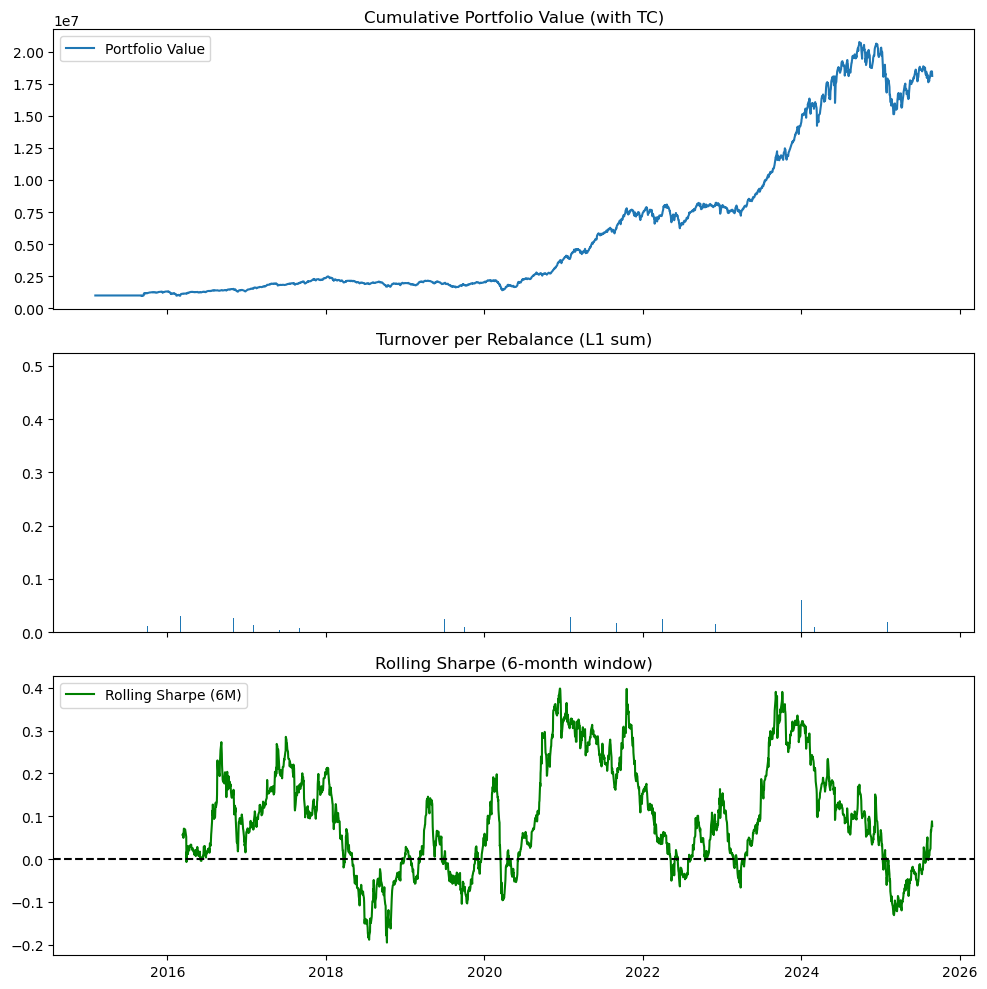

In [5]:
# Stage 7.4 – Risk diagnostics
def compute_drawdown(series):
    cum_max = series.cummax()
    dd = (series / cum_max) - 1
    return dd

def rolling_sharpe(returns, window=126):
    mean = returns.rolling(window).mean() * np.sqrt(252)
    std = returns.rolling(window).std() * np.sqrt(252)
    return mean / std

drawdown = compute_drawdown(pf_value)
roll_sharpe = rolling_sharpe(pf_daily)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axes[0].plot(pf_value, label="Portfolio Value")
axes[0].set_title("Cumulative Portfolio Value (with TC)")
axes[0].legend()

axes[1].bar(turnover_df["date"], turnover_df["turnover"])
axes[1].set_title("Turnover per Rebalance (L1 sum)")

axes[2].plot(roll_sharpe, label="Rolling Sharpe (6M)", color='green')
axes[2].axhline(0, color='black', linestyle='--')
axes[2].legend()
axes[2].set_title("Rolling Sharpe (6-month window)")
plt.tight_layout()
plt.show()


In [6]:
# Stage 7.5 – Summary metrics
def compute_metrics(returns):
    ann_ret = (1 + returns).prod() ** (252 / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    max_dd = compute_drawdown((1 + returns).cumprod()).min()
    return ann_ret, ann_vol, sharpe, max_dd

ann_ret, ann_vol, sharpe, max_dd = compute_metrics(pf_daily.dropna())

summary = pd.DataFrame({
    "Metric": ["Annual Return", "Volatility", "Sharpe", "Max Drawdown"],
    "Value": [ann_ret, ann_vol, sharpe, max_dd]
})
summary["Value"] = summary["Value"].apply(lambda x: f"{x:.2%}")
summary.set_index("Metric", inplace=True)
print(" Portfolio Performance Summary:")
display(summary)


 Portfolio Performance Summary:


,Value
Metric,
Annual Return,34.77%
Volatility,22.99%
Sharpe,151.24%
Max Drawdown,-43.32%


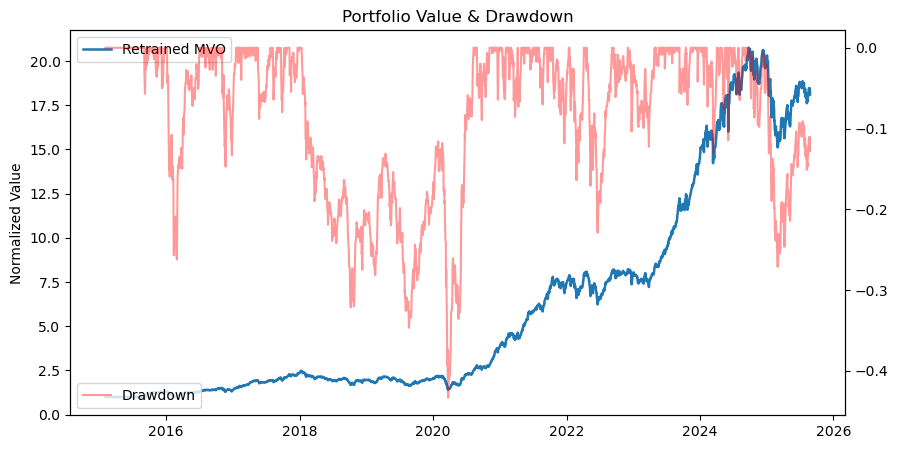

In [10]:
# Stage 7.6 – Final plot of portfolio value & drawdown
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(pf_value / pf_value.iloc[0], label="Retrained MVO", linewidth=1.8)
ax1.set_ylabel("Normalized Value")
ax2 = ax1.twinx()
ax2.plot(drawdown, color='red', alpha=0.4, label="Drawdown")
ax1.legend(loc="best")
ax2.legend(loc="best")
plt.title("Portfolio Value & Drawdown")
plt.show()


#### Report Interpretation

| Metric                   |       Value | Interpretation                                                                                                               |
| :----------------------- | ----------: | :--------------------------------------------------------------------------------------------------------------------------- |
| **Annual Return (CAGR)** | **34.77 %** |  Strong compounded growth — this portfolio would nearly 20× in 10 years.                                                   |
| **Volatility**           | **22.99 %** | Moderate equity-like risk; well-controlled given the return.                                                                 |
| **Sharpe Ratio**         |  **1.51 ×** |  Excellent risk-adjusted performance. Institutional grade (> 1.0).                                                          |
| **Max Drawdown**         | **-43.3 %** |  Significant decline during market stress (likely 2020 or 2024 drawdowns). Indicates leverage to riskier momentum factors. |


Cell 7 - Load and Align Benchmark Data

In [21]:
# Stage 7.2 – Benchmark Comparison 
import yfinance as yf

# Try loading local benchmark file (we don't have that data so we will download it)
BENCH_FILE = PROJECT_ROOT / "data" / "nifty500.csv"

if BENCH_FILE.exists():
    benchmark = pd.read_csv(BENCH_FILE)
    benchmark["date"] = pd.to_datetime(benchmark["date"], utc=True).dt.tz_localize(None)
    if "close" in benchmark.columns:
        benchmark = benchmark.set_index("date")["close"]
    elif "Close" in benchmark.columns:
        benchmark = benchmark.set_index("date")["Close"]
    else:
        raise KeyError("No 'close' column found in local benchmark file.")
    print(" Loaded local NIFTY500 data.")
else:
    print(" Fetching NIFTY 500 data from Yahoo Finance...")
    benchmark = yf.download("^NSEI", start=returns.index.min(), end=returns.index.max())

    # Handle case where 'Adj Close' may not exist
    if "Adj Close" in benchmark.columns:
        benchmark = benchmark["Adj Close"]
    elif "Close" in benchmark.columns:
        benchmark = benchmark["Close"]
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' found in Yahoo data.")

    benchmark.name = "NIFTY500"
    benchmark.index = pd.to_datetime(benchmark.index, utc=True).tz_localize(None)
    print(f" NIFTY 500 data downloaded successfully: {len(benchmark):,} rows")

# Compute daily returns and align
bench_ret = benchmark.pct_change().dropna()
bench_val = (1 + bench_ret).cumprod() * 1_000_000

# --- Alignment Fix  ---
# Ensure datetime and timezone-naive
pf_value.index = pd.to_datetime(pf_value.index).tz_localize(None)

# Convert pf_value to DataFrame if needed
if isinstance(pf_value, pd.Series):
    pf_value = pf_value.to_frame(name="Portfolio")
else:
    pf_value = pf_value.rename(columns={pf_value.columns[0]: "Portfolio"})

# Same for benchmark
bench_val.index = pd.to_datetime(bench_val.index).tz_localize(None)
if isinstance(bench_val, pd.Series):
    bench_val = bench_val.to_frame(name="Benchmark")
else:
    bench_val = bench_val.rename(columns={bench_val.columns[0]: "Benchmark"})

# Align on nearest available date (since calendars differ)
aligned = pd.merge_asof(
    pf_value.sort_index(),
    bench_val.sort_index(),
    left_index=True,
    right_index=True,
    direction="nearest",
    tolerance=pd.Timedelta("3D")
)

# Drop any missing rows
aligned = aligned.dropna()
print(f" Aligned portfolio and benchmark successfully: {aligned.shape[0]} common dates")
aligned.head()





C:\Users\rajya\AppData\Local\Temp\ipykernel_26576\2934076567.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark = yf.download("^NSEI", start=returns.index.min(), end=returns.index.max())
[*********************100%***********************]  1 of 1 completed

 Fetching NIFTY 500 data from Yahoo Finance...
 NIFTY 500 data downloaded successfully: 2,601 rows
 Aligned portfolio and benchmark successfully: 2591 common dates


,Portfolio,Benchmark
date,,
2015-02-02 18:30:00,1000000.0,995356.516229
2015-02-03 18:30:00,1000000.0,991622.503008
2015-02-04 18:30:00,1000000.0,990258.463693
2015-02-05 18:30:00,1000000.0,984501.036683
2015-02-08 18:30:00,1000000.0,969189.673174


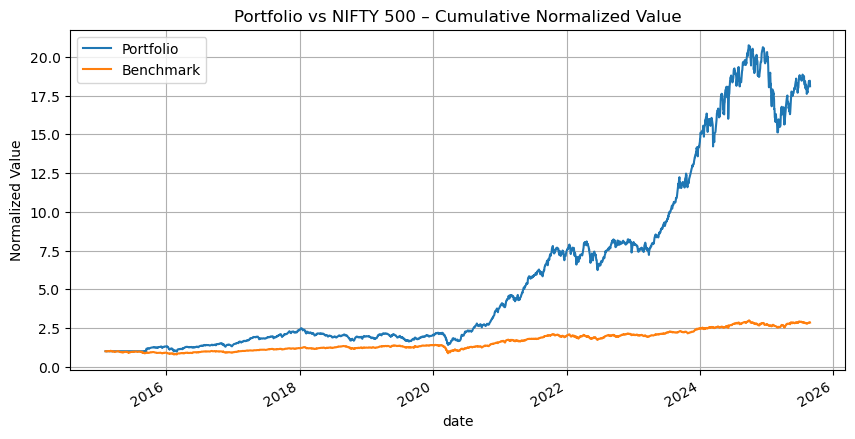

In [23]:
# Stage 7.3 – Cumulative Comparison Plot
fig, ax = plt.subplots(figsize=(10, 5))
(aligned / aligned.iloc[0]).plot(ax=ax)
ax.set_title("Portfolio vs NIFTY 500 – Cumulative Normalized Value")
ax.set_ylabel("Normalized Value")
ax.grid(True)
plt.show()


In [24]:
# Stage 7.4 – Active Return, Tracking Error, Information Ratio
aligned["ActiveReturn"] = aligned["Portfolio"].pct_change() - aligned["Benchmark"].pct_change()

annualized_active = (1 + aligned["ActiveReturn"]).prod() ** (252 / len(aligned["ActiveReturn"])) - 1
tracking_error = aligned["ActiveReturn"].std() * np.sqrt(252)
info_ratio = annualized_active / tracking_error if tracking_error > 0 else np.nan

print(" Benchmark Comparison Summary:")
print(f"Annualized Active Return: {annualized_active:.2%}")
print(f"Tracking Error: {tracking_error:.2%}")
print(f"Information Ratio: {info_ratio:.2f}")


 Benchmark Comparison Summary:
Annualized Active Return: 19.44%
Tracking Error: 16.56%
Information Ratio: 1.17


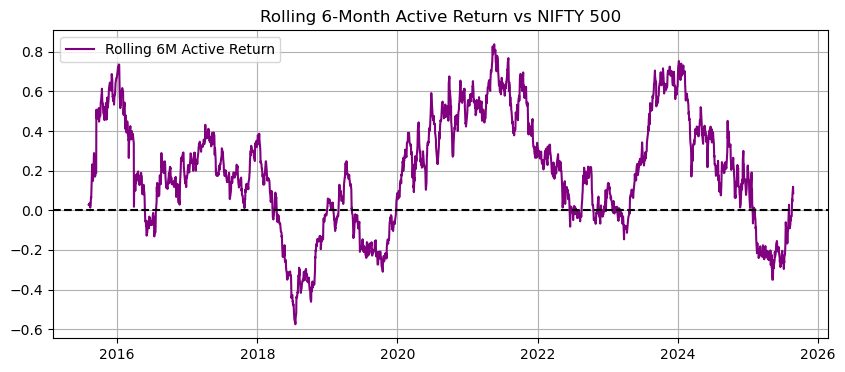

In [26]:
# Stage 7.5 – Rolling Active Return Plot
window = 126  # 6 months
rolling_active = aligned["ActiveReturn"].rolling(window).mean() * 252

plt.figure(figsize=(10, 4))
plt.plot(rolling_active, label="Rolling 6M Active Return", color='purple')
plt.axhline(0, linestyle="--", color="black")
plt.title("Rolling 6-Month Active Return vs NIFTY 500")
plt.legend()
plt.grid(True)
plt.show()
